# 1.0 Get Data Of Stock Market

* 本篇代码用来查询所有股票数据，所有导出的数据都将导出到stockdata文件夹内，方便管理查看。
* 平台api方面，国内用tushare，国外用的雅虎。
* 本篇代码也计划用来做数据清洗并且数据展示，处理好的文件也存在stockdata文件夹里面。

In [1]:
print("Hello,stock market")
from datetime import datetime
start_time = datetime.now()
import time
import numpy as np
## todo: calculating the time of import libraries
#先引入后面分析、可视化等可能用到的库
import tushare as ts
import pandas as pd
import matplotlib.pyplot as plt
#正常显示画图时出现的中文和负号
from pylab import mpl
import yfinance as yf
import matplotlib.dates as mdates
import seaborn as sns
# todo: solve chinese problem for plt
mpl.rcParams['font.sans-serif']=['SimHei']
mpl.rcParams['axes.unicode_minus']=False

#显示所有列
# pd.set_option('display.max_columns', 100)
# #显示所有行
# pd.set_option('display.max_rows', 100)
# #设置value的显示长度为100，默认为50
# pd.set_option('max_colwidth',100)
print("Load Time: ",datetime.now()-start_time)

Hello,stock market


D:\app\anaconda\envs\machineLearning\lib\site-packages\requests\__init__.py:109: RequestsDependencyWarning: urllib3 (2.0.2) or chardet (None)/charset_normalizer (2.1.1) doesn't match a supported version!
  warnings.warn(


Load Time:  0:00:00.656702


## 1.1 use tushare api get data

In [2]:
# login tushare, use token
pro = ts.pro_api('f7b384108cbed0026a4dfa35835f75b0fb9d04673a067e8b75d8810f')


def getStockCompanyInformation(status='L', stock_code=''):
    """
    得到目前所有的股票公司信息
    :param status: 上市状态 L上市 D退市 P暂停上市，默认是L
    :param stock_code: TS股票代码
    :return:
    """

    if stock_code== '':
        rawStockCompanyDataInTushare = pro.stock_basic(exchange='', list_status=status, fields='ts_code,symbol,fullname,enname,name,area,industry,list_date')
    else:
        rawStockCompanyDataInTushare = pro.stock_basic(ts_code=stock_code, exchange='', list_status=status, fields='ts_code,symbol,fullname,enname,name,area,industry,list_date')

    rawStockCompanyDataInTushare['ts_code']=rawStockCompanyDataInTushare['ts_code'].astype(str)
    rawStockCompanyDataInTushare['symbol']=rawStockCompanyDataInTushare['symbol'].astype('float64')
    rawStockCompanyDataInTushare['name']=rawStockCompanyDataInTushare['name'].astype(str)
    rawStockCompanyDataInTushare['area']=rawStockCompanyDataInTushare['area'].astype(str)
    rawStockCompanyDataInTushare['industry']=rawStockCompanyDataInTushare['industry'].astype(str)
    rawStockCompanyDataInTushare['fullname']=rawStockCompanyDataInTushare['fullname'].astype(str)
    rawStockCompanyDataInTushare['enname']=rawStockCompanyDataInTushare['enname'].astype(str)
    rawStockCompanyDataInTushare['list_date']=rawStockCompanyDataInTushare['list_date'].astype('float64')

    rawStockCompanyDataInTushare['list_date']=pd.to_datetime(rawStockCompanyDataInTushare['list_date'], format='%Y%m%d')
    return rawStockCompanyDataInTushare


# 拉取数据
def getDailyStockData(stock_code="",start="20130101",end="20230101"):
    """
    拉取股票日结交易信息，时间段默认 2018-1-1 到 2022-1-1，注意：该函数单次只能查询6000条记录。
    :param stock_code: 股票代码，默认为空，输入为空的时候，拉取这段时期所有股票的交易消息；若不为空，拉去这只股票这段时间的交易消息
    :param start: 开始日期
    :param end: 结束日期
    :return:
    """
    rawData = pro.daily(**{
        "ts_code": stock_code,
        "trade_date": "",
        "start_date": start,
        "end_date": end,
        "offset": "",
        "limit": "",
    }, fields=[
        "ts_code",
        "trade_date",
        "open",
        "high",
        "low",
        "close",
        "pre_close",
        "change",
        "pct_chg",
        "vol",
        "amount"
    ])
    rawData['ts_code']=rawData['ts_code'].astype(str)
    rawData['trade_date']=rawData['trade_date'].astype('float64')

    rawData['trade_date']=pd.to_datetime(rawData['trade_date'], format='%Y%m%d')
    return rawData


In [3]:
rawCompanyDataInTushare=getStockCompanyInformation()
print("The shape of the data frame: {}".format(rawCompanyDataInTushare.shape))
print("The types in the data frame {}".format(rawCompanyDataInTushare.dtypes))
rawCompanyDataInTushare

The shape of the data frame: (5187, 8)
The types in the data frame ts_code              object
symbol              float64
name                 object
area                 object
industry             object
fullname             object
enname               object
list_date    datetime64[ns]
dtype: object


,ts_code,symbol,name,area,industry,fullname,enname,list_date
0,000001.SZ,1.0,平安银行,深圳,银行,平安银行股份有限公司,"Ping An Bank Co., Ltd.",1991-04-03
1,000002.SZ,2.0,万科A,深圳,全国地产,万科企业股份有限公司,"China Vanke Co.,Ltd.",1991-01-29
2,000004.SZ,4.0,ST国华,深圳,软件服务,深圳国华网安科技股份有限公司,Shenzhen Guohua Network Security Technology Co...,1991-01-14
3,000005.SZ,5.0,ST星源,深圳,环境保护,深圳世纪星源股份有限公司,Shenzhen Fountain Corporation,1990-12-10
4,000006.SZ,6.0,深振业A,深圳,区域地产,深圳市振业(集团)股份有限公司,"Shenzhen Zhenye(Group) Co., Ltd",1992-04-27
...,...,...,...,...,...,...,...,...
5182,873305.BJ,873305.0,九菱科技,None,None,荆州九菱科技股份有限公司,"Jingzhou Julin Science And Technology Co.,Ltd",2022-12-21
5183,873339.BJ,873339.0,恒太照明,None,None,江苏恒太照明股份有限公司,"Jiangsu Ever-Tie Lighting Co., Ltd",2022-11-17
5184,873527.BJ,873527.0,夜光明,None,None,浙江夜光明光电科技股份有限公司,"Zhejiang Ygm Technology Co.,Ltd",2022-10-27
5185,873593.BJ,873593.0,鼎智科技,None,None,江苏鼎智智能控制科技股份有限公司,Jiangsu DINGS Intelligent Control Technology C...,2023-04-13


In [4]:
rawDailyDataInTushare=getDailyStockData()
print("The shape of the data frame: {}".format(rawDailyDataInTushare.shape))
print("The types in the data frame:\n{}".format(rawDailyDataInTushare.dtypes))
print("The unique stock code: {}".format(len(rawDailyDataInTushare['ts_code'].unique())))
rawDailyDataInTushare

The shape of the data frame: (6000, 11)
The types in the data frame:
ts_code               object
trade_date    datetime64[ns]
open                 float64
high                 float64
low                  float64
close                float64
pre_close            float64
change               float64
pct_chg              float64
vol                  float64
amount               float64
dtype: object
The unique stock code: 5061


,ts_code,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount
0,002198.SZ,2022-12-30,6.39,6.57,6.33,6.52,6.40,0.12,1.8750,101579.12,65646.164
1,002199.SZ,2022-12-30,6.36,6.43,6.28,6.39,6.29,0.10,1.5898,38684.00,24640.014
2,002194.SZ,2022-12-30,9.13,9.26,9.07,9.21,9.10,0.11,1.2088,101101.41,92895.425
3,002181.SZ,2022-12-30,5.28,5.52,5.28,5.46,5.31,0.15,2.8249,547665.70,297495.407
4,002195.SZ,2022-12-30,1.99,2.02,1.98,2.01,1.98,0.03,1.5152,444728.72,89088.620
...,...,...,...,...,...,...,...,...,...,...,...
5995,300185.SZ,2022-12-29,2.43,2.43,2.38,2.39,2.43,-0.04,-1.6461,169697.00,40744.559
5996,002212.SZ,2022-12-29,9.51,9.93,9.48,9.85,9.59,0.26,2.7112,166568.42,163068.690
5997,002213.SZ,2022-12-29,16.37,16.37,15.61,15.68,14.88,0.80,5.3763,238641.86,386408.221
5998,002397.SZ,2022-12-29,4.54,4.67,4.51,4.54,4.60,-0.06,-1.3043,127870.79,58483.435


In [5]:
##test
testDailyStockData=getDailyStockData(stock_code="000006.SZ")
testDailyStockData

,ts_code,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount
0,000006.SZ,2022-12-30,6.29,6.46,6.21,6.30,6.13,0.17,2.7732,1280164.06,8.071626e+05
1,000006.SZ,2022-12-29,6.60,6.65,6.13,6.13,6.81,-0.68,-9.9853,2067778.94,1.305957e+06
2,000006.SZ,2022-12-28,6.47,7.17,6.40,6.81,6.64,0.17,2.5602,2646897.32,1.789639e+06
3,000006.SZ,2022-12-27,6.00,6.64,5.96,6.64,6.04,0.60,9.9338,2469265.08,1.612829e+06
4,000006.SZ,2022-12-26,5.69,6.18,5.65,6.04,5.91,0.13,2.1997,1502166.93,8.940131e+05
...,...,...,...,...,...,...,...,...,...,...,...
2308,000006.SZ,2013-01-10,5.02,5.12,4.99,5.06,5.01,0.05,1.0000,231290.95,1.167205e+05
2309,000006.SZ,2013-01-09,5.02,5.07,4.95,5.01,5.08,-0.07,-1.3800,218039.31,1.094010e+05
2310,000006.SZ,2013-01-08,5.15,5.30,5.01,5.08,4.92,0.16,3.2500,472007.79,2.412159e+05
2311,000006.SZ,2013-01-07,4.90,4.94,4.82,4.92,4.93,-0.01,-0.2000,132315.27,6.452564e+04


In [6]:
###由于Toshare社区限制每次查询只能拿到 6000 行日结交易信息（每日每公司为一行），而且每分钟只能查500次。为了得到当前所有上市公司，每次查询只查一家上市公司而且将会延迟0.2秒
def bindDailyAndCompanyInformation():
    notIncludedData=['name']

    startTime=datetime.now()
    companies=getStockCompanyInformation()
    bindData=pd.DataFrame()
    i=2
    for company in companies['ts_code'].to_numpy():
        dailyData=getDailyStockData(stock_code=company)
        for header in companies.columns:
            if header!="ts_code":
                #test only
                # print("------------------------------------")
                # print(companies[companies['ts_code'] == company][header].values.repeat(5))
                # print(dailyData.shape[0])
                # print("------------------------------------")
                dailyData[header]= companies[companies['ts_code'] == company][header].values.repeat(dailyData.shape[0])

        dailyData=dailyData.drop(columns=notIncludedData)
        bindData=bindData.append(dailyData)
        #time.sleep(0.15)
        ###########test only
        #print(dailyData)
        # if i==1:
        #     break
        # else:
        #     i-=1
        ###########
    timeConsume=datetime.now()-startTime
    print("Run time: {}".format(timeConsume))
    return bindData


In [7]:
###此cell仅用于下载股票数据，由于信息量庞大，可导入下好的 TushareRawData.csv 文件即可
# theBindDataInTushare=bindDailyAndCompanyInformation()
# print("The shape of the data frame: {}".format(theBindDataInTushare.shape))
# print("The types in the data frame:\n{}".format(theBindDataInTushare.dtypes))
# print("The unique stock code: {}".format(len(theBindDataInTushare['ts_code'].unique())))
# theBindDataInTushare.to_csv('stockData/TushareRawData.csv', header=theBindDataInTushare.columns, index=False)

In [8]:
###此cell是本地读取tushare股票信息，如果本地有csv文件就用这个，并且注释上一个cell，如果没下载csv文件就取消注释上一个cell
theBindDataInTushare=pd.read_csv('stockData/TushareRawData.csv')
print("The shape of the data frame: {}".format(theBindDataInTushare.shape))
print("The types in the data frame:\n{}".format(theBindDataInTushare.dtypes))
print("The unique stock code: {}".format(len(theBindDataInTushare['ts_code'].unique())))

The shape of the data frame: (7792078, 17)
The types in the data frame:
ts_code        object
trade_date     object
open          float64
high          float64
low           float64
close         float64
pre_close     float64
change        float64
pct_chg       float64
vol           float64
amount        float64
symbol        float64
area           object
industry       object
fullname       object
enname         object
list_date      object
dtype: object
The unique stock code: 5061


In [9]:
###todo 不知道为什么有100家公司查不到，手动查询看看情况，然后手动合并吧
missedCompany=[]
bindCompany=theBindDataInTushare['ts_code'].unique()
for code in rawCompanyDataInTushare['ts_code'].values:
    if code not in bindCompany:
        missedCompany.append(code)


# for code in missedCompany:
#     print("-------------------------------------")
#     print(getDailyStockData(stock_code=code,end="20220505"))
#     print(getStockCompanyInformation(stock_code=code))
#     print("-------------------------------------")

print("The num of miss company: {}".format(len(missedCompany)))

###todo 这些股票查不到，这些公司基本都是2023年上市的，可能数据还没更新吧

The num of miss company: 126


In [10]:
print("The number of industry: {}".format(len(theBindDataInTushare['industry'].unique())))
print("The exact number of company: {}".format(len(theBindDataInTushare['ts_code'].unique())))
# print("--------------------------------------------------------\n"+"The industries: {}".format(theBindDataInTushare['industry'].unique()))

theCounter={}
uniqueList=rawCompanyDataInTushare['industry'].values
for industry in uniqueList:
    if industry in theCounter:
        theCounter[industry]+=1
    else:
        theCounter[industry]=1
theCounter=sorted(theCounter.items(), key = lambda kv:kv[1],reverse=True)
print("--------------------------------------------------------\n"+"the number of company in different industry:\n {}".format(theCounter))

The number of industry: 111
The exact number of company: 5061
--------------------------------------------------------
the number of company in different industry:
 [('电气设备', 289), ('软件服务', 270), ('元器件', 262), ('专用机械', 226), ('化工原料', 223), ('None', 197), ('汽车配件', 196), ('医疗保健', 167), ('半导体', 155), ('化学制药', 139), ('通信设备', 131), ('环境保护', 128), ('建筑工程', 118), ('机械基件', 103), ('互联网', 90), ('食品', 85), ('电器仪表', 84), ('家用电器', 80), ('中成药', 73), ('生物制药', 71), ('服饰', 67), ('家居用品', 62), ('塑料', 61), ('IT设备', 58), ('小金属', 55), ('农药化肥', 54), ('区域地产', 52), ('文教休闲', 52), ('证券', 51), ('广告包装', 51), ('仓储物流', 48), ('航空', 46), ('运输设备', 45), ('纺织', 44), ('供气供热', 43), ('银行', 42), ('农业综合', 41), ('医药商业', 37), ('影视音像', 37), ('百货', 36), ('全国地产', 34), ('其他建材', 33), ('火力发电', 32), ('装修装饰', 31), ('工程机械', 31), ('造纸', 31), ('染料涂料', 31), ('铝', 31), ('多元金融', 30), ('化纤', 29), ('出版业', 29), ('矿物制品', 29), ('普钢', 26), ('煤炭开采', 25), ('水泥', 23), ('汽车整车', 23), ('新型电力', 22), ('机床制造', 21), ('商贸代理', 20), ('白酒', 20), ('钢加工', 20), ('

### test science data

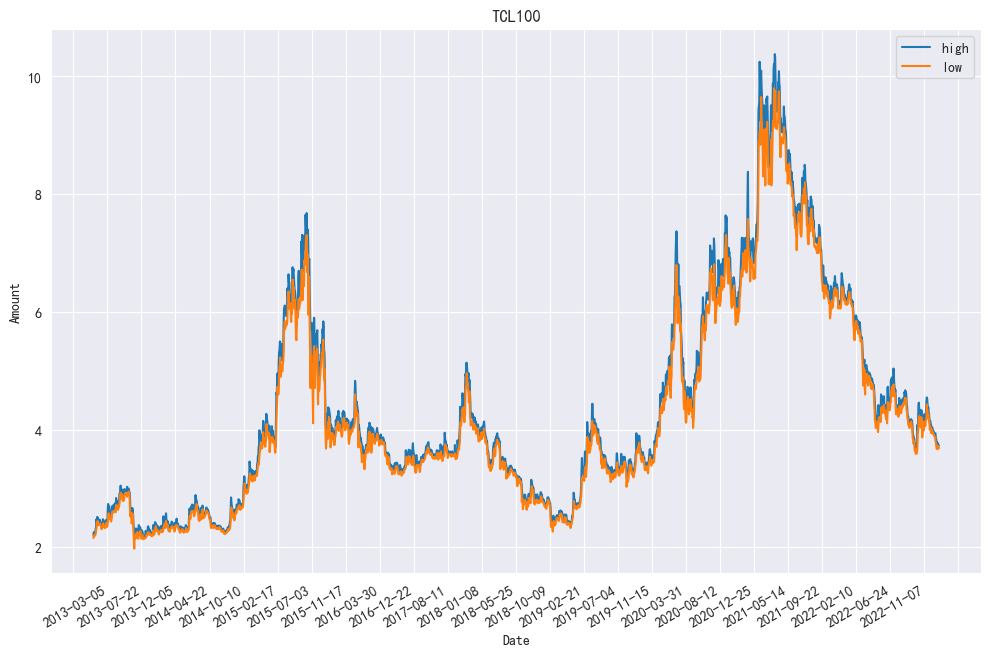

,ts_code,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount,symbol,area,industry,fullname,enname,list_date
134489,000100.SZ,2013-01-04,2.20,2.21,2.16,2.21,2.19,0.02,0.9100,1603589.32,350309.8057,100.0,广东,元器件,TCL科技集团股份有限公司,Tcl Technology Group Corporation,2004-01-30
134488,000100.SZ,2013-01-07,2.21,2.26,2.20,2.25,2.21,0.04,1.8100,2446465.65,548610.2820,100.0,广东,元器件,TCL科技集团股份有限公司,Tcl Technology Group Corporation,2004-01-30
134487,000100.SZ,2013-01-08,2.25,2.25,2.21,2.24,2.25,-0.01,-0.4400,1223850.55,273030.6377,100.0,广东,元器件,TCL科技集团股份有限公司,Tcl Technology Group Corporation,2004-01-30
134486,000100.SZ,2013-01-09,2.23,2.24,2.20,2.22,2.24,-0.02,-0.8900,1173131.58,260120.9124,100.0,广东,元器件,TCL科技集团股份有限公司,Tcl Technology Group Corporation,2004-01-30
134485,000100.SZ,2013-01-10,2.22,2.23,2.20,2.22,2.22,0.00,0.0000,805958.97,178699.0808,100.0,广东,元器件,TCL科技集团股份有限公司,Tcl Technology Group Corporation,2004-01-30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132257,000100.SZ,2022-12-26,3.72,3.76,3.72,3.75,3.73,0.02,0.5362,533547.21,199601.1210,100.0,广东,元器件,TCL科技集团股份有限公司,Tcl Technology Group Corporation,2004-01-30
132256,000100.SZ,2022-12-27,3.76,3.77,3.73,3.75,3.75,0.00,0.0000,514072.58,192359.1930,100.0,广东,元器件,TCL科技集团股份有限公司,Tcl Technology Group Corporation,2004-01-30
132255,000100.SZ,2022-12-28,3.75,3.76,3.71,3.73,3.75,-0.02,-0.5333,690095.26,257697.4930,100.0,广东,元器件,TCL科技集团股份有限公司,Tcl Technology Group Corporation,2004-01-30
132254,000100.SZ,2022-12-29,3.72,3.73,3.68,3.70,3.73,-0.03,-0.8043,839641.79,310683.4180,100.0,广东,元器件,TCL科技集团股份有限公司,Tcl Technology Group Corporation,2004-01-30


In [11]:
TCLStock=theBindDataInTushare[theBindDataInTushare['ts_code']=="000100.SZ"].sort_values(by='trade_date',ascending=True)
plt.figure(figsize=(12,8))
ax = plt.gca()
locator = mdates.DayLocator(interval=30*3)
ax.xaxis.set_major_locator(locator)
plt.gcf().autofmt_xdate()
plt.plot(TCLStock['trade_date'],TCLStock['high'],label="high")
plt.plot(TCLStock['trade_date'],TCLStock['low'],label="low")
plt.xlabel("Date")
plt.ylabel("Amount")
plt.title('TCL100')
plt.legend()   #打上标签
plt.show()
TCLStock

### 1.1.1 大盘整体趋势

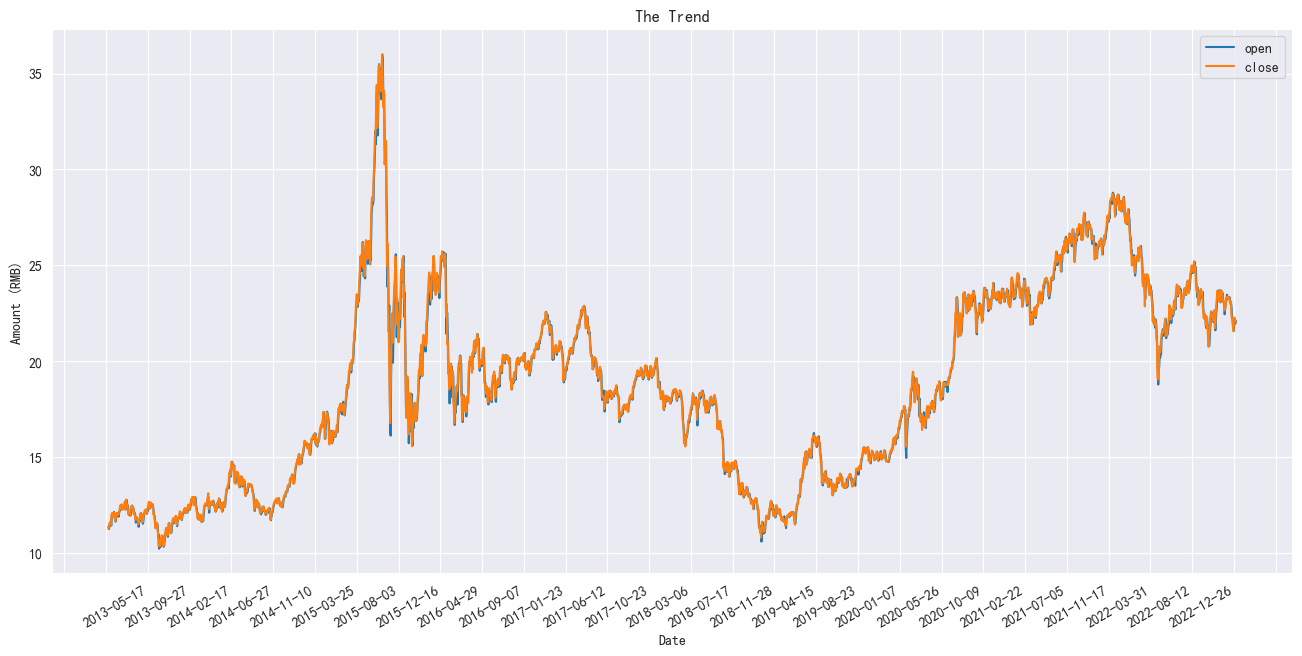

,close,open
trade_date,,
2013-01-04,11.260674,11.363834
2013-01-07,11.402936,11.238364
2013-01-08,11.536381,11.375546
2013-01-09,11.543813,11.509729
2013-01-10,11.601051,11.522294
...,...,...
2022-12-26,22.060998,21.562804
2022-12-27,22.272486,22.097048
2022-12-28,22.043449,22.206167


In [12]:
theTrendResult=theBindDataInTushare.groupby('trade_date')[['close','open']].mean()

plt.figure(figsize=(16,8))
ax = plt.gca()
locator = mdates.DayLocator(interval=30*3)
ax.xaxis.set_major_locator(locator)
plt.gcf().autofmt_xdate()
plt.plot(theTrendResult['open'],label="open")
plt.plot(theTrendResult['close'],label="close")
plt.xlabel("Date")
plt.ylabel("Amount (RMB)")
plt.title('The Trend')
plt.legend()   #打上标签
plt.show()

theTrendResult

### 1.1.2 各个行业领域大盘

注意: 该cell运行会绘制大量的图表，图表都被保存好了，如果不想运行可以查看路径stockData/tableForIndustry/raw

In [13]:
###生成各个领域的平均总览图标
#
# for i in list(theIndustryGroupedTrendResult):
#     plt.figure(figsize=(16,8))
#     x = np.arange(0, 300, 20)
#     plt.yticks(x)
#     i[-1]['close'].plot()
#     plt.xlabel("Date")
#     plt.ylabel("Amount (RMB)")
#     plt.title("The Industry Trend: {}".format(i[-1]['industry'].unique()[0]))
#     plt.legend()   #打上标签
#
#     ###下载图表
#     # plt.savefig("stockData/tableForIndustry/raw/industryTablesFor{}.jpg".format(format(i[-1]['industry'].unique()[0])))
#
# plt.show()
#
# theIndustryTrendResult

### 1.1.3 数据异常处理 (industry 为 none，建议优化)
注意: 行业总共110种，很多，在模型里面本身是建议降维的; 而且有些行业重复，例如金属被分成好几个领域，但是不建议归类，因为这些行业的走势都不一样，建议保留，等后续讨论。

目前计划拿到这些公司的产品与介绍，nle分析并将其分类到合适的种类

In [14]:
### 目前已知的行业有110种，还有一种没有归类，现在尝试归类
print("the number of company with none industry: {}".format(len(theBindDataInTushare[theBindDataInTushare['industry'] == "None"]['ts_code'].unique())))


###查询行业缺失的公司简介与产品名称
# noneIndustryCodeList=theBindDataInTushare[theBindDataInTushare['industry'] == "None"]['ts_code'].unique()
# noneIndustryDF=pd.DataFrame()
# now=datetime.now()
# for code in noneIndustryCodeList:
#     ###该接口每分钟最多10次，尼玛得搞16分钟，之后会存在stockData/CompanyIntroductionWithNoneIndustry.csv
#     noneIndustrydf = pro.stock_company(ts_code=code, fields='ts_code,introduction,main_business')
#     noneIndustryDF=noneIndustryDF.append(noneIndustrydf)
#     time.sleep(6)
#
# noneIndustryDF.to_csv("stockData/CompanyIntroductionWithNoneIndustry.csv")
# print("cost time: {}".format(datetime.now()-now))



###查询行业已知的公司简介与产品名称
# knownIndustryCodeList=theBindDataInTushare[theBindDataInTushare['industry'] != "None"]['ts_code'].unique()
# knownIndustryDF=pd.DataFrame()
# now=datetime.now()
# for code in knownIndustryCodeList:
#     ###该接口每分钟最多10次，尼玛得搞16分钟，之后会存在stockData/CompanyIntroductionWithNoneIndustry.csv
#     knownIndustrydf = pro.stock_company(ts_code=code, fields='ts_code,introduction,main_business')
#     knownIndustryDF=knownIndustryDF.append(knownIndustrydf)
#     time.sleep(6)
#
# knownIndustryDF.to_csv("stockData/CompanyIntroductionWithKnownIndustry.csv")
# print("cost time: {}".format(datetime.now()-now))


noneIndustryDF=pd.read_csv("stockData/CompanyIntroductionWithNoneIndustry.csv")

knownIndustryDF=pd.read_csv("stockData/CompanyIntroductionWithKnownIndustry.csv")

the number of company with none industry: 0


In [15]:
noneIndustryDF['industry']=noneIndustryDF.apply(lambda x:rawCompanyDataInTushare[x['ts_code']==rawCompanyDataInTushare['ts_code']]['industry'].values[0],axis=1)
noneIndustryDF

,Unnamed: 0,ts_code,introduction,main_business,industry
0,0,300309.SZ,公司是国内知名的石油测井设备专业制造商。主营业务是石油测井仪器的研发、生产、销售和现场技术服...,"公司的主营业务是石油测井仪器的研发,生产,销售和现场技术服务,以及利用测井仪器为油田客户提供...",None
1,1,300330.SZ,公司是一家国有控股的基于射频识别技术(RFID)的电子收费与支付系统解决方案供应商和设备供应...,"公司的主营业务为轨道交通自动售检票系统(AFC),城市通卡自动收费系统(主要包括城市公交一卡...",None
2,2,430047.BJ,公司是一家创新型生物制药企业，专业从事基因治疗药物、重组蛋白质类药物和眼科用药的研发、生产与...,"基因工程蛋白质类药物,基因治疗药物和眼科用药物的研发,生产及销售",None
3,3,430090.BJ,公司通过了ISO9001-2008质量体系认证，在多媒体视频解决方案的研发、组装及系统集成服...,"公司主营业务为向金融,展览展示,教育,影院等各行业用户提供领先的视觉综合解决方案及产品.",None
4,4,430139.BJ,公司2001年成立于上海张江高科技园区。公司是一家专业从事集成电路测试技术研究开发、芯片设计...,"晶圆测试,IC成品测试,测试验证分析,测试技术研究,程序开发,自有设备租赁",None
...,...,...,...,...,...
159,159,873169.BJ,公司是一家专业从事紧固件研发、生产及销售业务的高新技术企业公司凭借优质的产品质量和高效的服务...,"公司产品主要包括高精密螺栓组件,高强度,耐低温螺栓,自锁螺母等,产品规格涵盖M3-M48的各...",None
160,160,873223.BJ,公司的主营业务为紧固件的研发、生产和销售，主要产品有铜钉、铜件、铜套、SMD、铝件、钢件、铆...,"精密紧固件,连接件,结构件等精密金属零部件的研发,制造和销售",None
161,161,873305.BJ,公司的主营业务为粉末冶金零件的研发、生产和销售。主要产品涉及汽车零件、家电零件两个领域，包括...,"粉末冶金制品和磁性材料的研发,生产和销售",None
162,162,873339.BJ,公司自2013年成立以来，就致力于LED灯具的研发、生产、销售。公司主营业务为LED照明产品...,LED照明灯具,None


In [16]:
knownIndustryDF['industry']=knownIndustryDF.apply(lambda x:rawCompanyDataInTushare[x['ts_code']==rawCompanyDataInTushare['ts_code']]['industry'].values[0],axis=1)
knownIndustryDF=knownIndustryDF[knownIndustryDF['industry']!='None']
print("行业数量（不包括None）: {}\n行业:{}".format(len(knownIndustryDF['industry'].unique()),knownIndustryDF['industry'].unique()))
knownIndustryDF

行业数量（不包括None）: 110
行业:['银行' '全国地产' '软件服务' '环境保护' '区域地产' '其他商业' '运输设备' '电气设备' '建筑工程' '玻璃' '家用电器'
 '服饰' '农业综合' '元器件' '水泥' '汽车服务' '火力发电' '医药商业' '汽车配件' '综合类' '新型电力' '多元金融'
 '装修装饰' '房产服务' '商品城' '石油加工' '铅锌' '通信设备' 'IT设备' '港口' '机场' '石油贸易' '空运'
 '生物制药' '商贸代理' '化学制药' '影视音像' '工程机械' '证券' '化纤' '供气供热' '农药化肥' '机床制造' '百货'
 '中成药' '酒店餐饮' '路桥' '旅游景点' '造纸' '医疗保健' '食品' '黄金' '化工原料' '专用机械' '水运' '日用化工'
 '旅游服务' '文教休闲' '出版业' '机械基件' '汽车整车' '煤炭开采' '铁路' '染料涂料' '白酒' '农用机械' '林业'
 '水务' '水力发电' '互联网' '广告包装' '铝' '其他建材' '批发业' '保险' '小金属' '铜' '普钢' '航空' '饲料'
 '特种钢' '种植业' '焦炭加工' '纺织' '啤酒' '超市连锁' '钢加工' '矿物制品' '渔业' '软饮料' '化工机械' '塑料'
 '红黄酒' '仓储物流' '家居用品' '摩托车' '石油开采' '轻工机械' '电器仪表' '半导体' '乳制品' '纺织机械' '电器连锁'
 '陶瓷' '橡胶' '公路' '公共交通' '船舶' '电信运营' '园区开发']


,Unnamed: 0,ts_code,introduction,main_business,industry
0,0,000001.SZ,公司是深圳发展银行股份有限公司以吸收合并原平安银行股份有限公司的方式完成两行整合并更名后的银...,"主要业务:贷款,拆借,存放等同业业务,债券投资.",银行
1,0,000002.SZ,公司成立于1984年，1988年进入房地产行业，经过三十余年的发展，已成为国内领先的城市配套...,房地产开发和物业服务,全国地产
2,0,000004.SZ,公司创立于1981年，1990年12月1日起在深圳证券交易所挂牌交易，是深交所首家挂牌的上市...,"主要业务:移动互联网游戏业务,移动应用安全服务业务",软件服务
3,0,000005.SZ,公司是中国早期大规模介入酒店式公寓服务业的公司之一，中国早期上市的公司之一。公司从事的主要业...,"主要业务:交通及基础设施经营,低碳技术集成和环境处理服务,不动产开发管理及工程监理,酒店经营...",环境保护
4,0,000006.SZ,公司是深圳市国有资产监督管理委员会直管的国有上市公司，公司以房地产开发经营为主营业务，具备国...,"主要产品或提供的服务:提供商品住宅,以及提供物业租赁服务.",区域地产
...,...,...,...,...,...
4892,0,688799.SH,公司自创立以来，秉承“科技服务健康”的企业宗旨，遵循“潜心制药，诚信待人”的企业经营理念，坚...,"主营业务为药品制剂和原料药的研发,生产和销售.",化学制药
4893,0,688800.SH,公司是专业从事连接系统产品的研发、生产、销售和服务的高新技术企业。自设立伊始，公司始终以连接...,"公司是从事连接系统产品的研发,生产,销售和售后服务的综合解决方案提供商,主要产品包括电子元件...",元器件
4894,0,688819.SH,公司是一家以电动轻型车绿色动力电池业务为主，集电动特种车绿色动力电池、新能源汽车动力电池、汽...,"以电动轻型车动力电池业务为主,集电动特种车动力电池,新能源汽车动力电池,汽车起动启停电池,储...",电气设备
4895,0,688981.SH,公司是全球领先的集成电路晶圆代工企业之一，也是中国大陆技术最先进、规模最大、配套服务最完善、...,"主要为客户提供0.35微米至14纳米多种技术节点,不同工艺平台的集成电路晶圆代工及配套服务",半导体


In [73]:
###分词
import jieba
import re

def getStopWords(url):
    with open("NLP/stopwords/hit_stopwords.txt",'r',encoding='utf8') as f:
        stopword = f.readlines()
    return [i.replace('\n','') for i in stopword]

def tokenizPara(text,stopword):
    sentences=re.split('，|_|-|!|。|, ',text.strip())
    cutSentences=[]

    for sentence in sentences:
        ex="///".join(jieba.lcut(sentence))
        cutSentences+=ex.split('///')

    afterStop=list(set(cutSentences).difference(set(stopword)))
    afterStop=[i for i in afterStop if len(i)>1 and not i.isdigit()]
    return afterStop

def getVector(words):
    """
    得到该句子的词向量总和
    :param words: 字符串列表
    """
    return

###加载stopword
cn_stopwords=getStopWords("NLP/stopwords/cn_stopwords.txt")
baidu_stopword=getStopWords("NLP/stopwords/baidu_stopwords.txt")
hit_stopword=getStopWords("NLP/stopwords/hit_stopwords.txt")
scu_stopword=getStopWords("NLP/stopwords/scu_stopwords.txt")
myStopword=['一家','']
stopword_list=cn_stopwords+hit_stopword+baidu_stopword+scu_stopword+myStopword


unknownIndustryParagraphs=[]
for item in noneIndustryDF.values:
    tokens=tokenizPara(item[2],stopword_list)
    unknownIndustryParagraphs.append(tokens)

knownIndustryParagraphs=[]
for item in knownIndustryDF.values:
    tokens=tokenizPara(item[2],stopword_list)
    knownIndustryParagraphs.append(tokens)


# print("------------------------------------\n"
#       "unknowIndustry:\n{}"
#       "\n------------------------------------\n"
#       "knowIndustry:\n{}".format(unknownIndustryParagraphs[:3],knownIndustryParagraphs[:3]))

knownIndustryDF['keyword']=knownIndustryParagraphs
noneIndustryDF['keyword']=unknownIndustryParagraphs
###根据行业合并文本

introductionByIndustry=pd.DataFrame()
for intro in list(knownIndustryDF.groupby('industry')):
    paras=[]
    AllIntroduction=[]
    for para in intro[1][['keyword','introduction']].values:
        paras+=para[0]
        AllIntroduction.append(para[1])

    row={'industry':intro[0],'keywords':[paras],'AllIntro':[AllIntroduction]}
    introductionByIndustry=pd.concat([pd.DataFrame.from_dict(row),introductionByIndustry])

introductionByIndustry['cut_keywords']=introductionByIndustry.apply(lambda x:" ".join(x['keywords']), axis=1)

introductionByIndustry

,industry,keywords,AllIntro,cut_keywords
0,黄金,"[最大, 银等, 企业, 著名品牌, Vatokoula, 主要, 有色金属, 资金, 矿产...",[公司主要从事矿产开发与房地产业投资。公司自2009年开始进入矿业开发领域，投资开发的矿种以...,最大 银等 企业 著名品牌 Vatokoula 主要 有色金属 资金 矿产 科拉 未来 联合...
0,饲料,"[以上, 关键技术, 营养, 贸易, 科学技术, 农产品, 技术, 研发, 健康, 正虹原,...",[公司是一家以研发生产销售饲料产品为主营业务，拥有自主知识产权的大型企业集团。公司除进行饲料...,以上 关键技术 营养 贸易 科学技术 农产品 技术 研发 健康 正虹原 从事 正虹牌 育种 ...
0,食品,"[行业, 古船, 重视, 博览会, 几十项, 最具, 十大, 股份, 首家, 国际, 人民,...",[公司是海南省首家A、B股上市公司，公司原主业为房地产开发、酒店旅游、物业管理，后经过重大资...,行业 古船 重视 博览会 几十项 最具 十大 股份 首家 国际 人民 餐饮 旅游 评为 明显...
0,陶瓷,"[釉面砖, 养老, 服务体系, 3C, 领域, 工作, 多个, 高级, 方面, 权威机构, ...",[公司是专业生产和销售高级玻化石和高级釉面砖系列产品的企业，主营业务为玻化砖、釉面砖的生产与...,釉面砖 养老 服务体系 3C 领域 工作 多个 高级 方面 权威机构 健康 绿色建材 战略 ...
0,银行,"[E通, 提升, 两行, 精品, 深圳发展银行, 领域, 先进, 数字化, 完成, 股份, ...",[公司是深圳发展银行股份有限公司以吸收合并原平安银行股份有限公司的方式完成两行整合并更名后的...,E通 提升 两行 精品 深圳发展银行 领域 先进 数字化 完成 股份 技术 支持 特色 广泛...
...,...,...,...,...
0,互联网,"[强有力, 展示, 更加, 迅速, 行业, 重视, 云端, 获客, 互联网, 目前, 储备,...",[公司是国内为数不多的互联网企业服务商，主要以“连锁化”和“互联网化”的O2O模式为中小微企...,强有力 展示 更加 迅速 行业 重视 云端 获客 互联网 目前 储备 共享 线上 覆盖 技术...
0,乳制品,"[省份, 责任事故, 营养, 完善, 农产品, 上户, 研发, 清晨, 百强, 广泛, 认可...",[公司专注于乳制品及乳饮料的研发、生产和销售，并以低温乳制品、低温乳饮料为主打产品。作为城市...,省份 责任事故 营养 完善 农产品 上户 研发 清晨 百强 广泛 认可 饮用 学生 GMP ...
0,中成药,"[率先, 行业, 制作, 物质, 最具, 胶类, 阿胶, 传承, 技术, 研发, 内部, 国...",[公司系国家高新技术企业、国家级创新型企业、国家胶类中药工程技术研究中心、国家胶类中药标准制...,率先 行业 制作 物质 最具 胶类 阿胶 传承 技术 研发 内部 国际 中药 百强 高新技术...
0,专用机械,"[导弹, 企业, 口径, 地区, 活塞, 殊荣, 超硬, 兵器工业集团公司, 飞机, 国家,...",[公司是隶属于中国兵器工业集团公司的一家百年老企，公司产品涉及大口径炮弹、火箭弹、导弹、子弹...,导弹 企业 口径 地区 活塞 殊荣 超硬 兵器工业集团公司 飞机 国家 名牌 成都市 材料 ...


In [18]:
###todo 开始准备句向量
def buildWordVector1(sentence,size,w2v_model):
    vec =np.zeros(size).reshape((1,size))
    data_vec=np.zeros(size).reshape((1,size))
    for word in sentence:
        print(word)
        vec=w2v_model[word].reshape((1,size))
        print(vec)
        data_vec +=vec
    print("句子向量：")
    print(data_vec)
    return data_vec




In [19]:
###todo 验证


In [20]:
### todo 泛化

## 1.2 use yfinance (雅虎非官方API) api get stock data

In [21]:
#测试api
data = yf.download(tickers='AMD',start='2013-01-1',end='2023-01-01')
print("The types in the data frame:\n{}".format(data.dtypes))
data

[*********************100%***********************]  1 of 1 completed
The types in the data frame:
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-01-02,2.550000,2.570000,2.450000,2.530000,2.530000,27214800
2013-01-03,2.520000,2.590000,2.460000,2.490000,2.490000,24966900
2013-01-04,2.510000,2.590000,2.490000,2.590000,2.590000,22054200
2013-01-07,2.610000,2.700000,2.600000,2.670000,2.670000,25575200
2013-01-08,2.720000,2.760000,2.640000,2.670000,2.670000,29140800
...,...,...,...,...,...,...
2022-12-23,63.110001,64.660004,62.720001,64.519997,64.519997,45923000
2022-12-27,63.869999,64.279999,62.970001,63.270000,63.270000,36086000
2022-12-28,62.540001,63.540001,61.959999,62.570000,62.570000,39526500


In [22]:
amd = yf.Ticker("AMD")
info=pd.DataFrame.from_dict(amd.info)
print("The types in the data frame:\n{}".format(info.dtypes))
info

The types in the data frame:
address1              object
city                  object
state                 object
zip                   object
country               object
                      ...   
grossMargins         float64
ebitdaMargins        float64
operatingMargins     float64
financialCurrency     object
trailingPegRatio     float64
Length: 122, dtype: object


,address1,city,state,zip,country,phone,website,industry,industryDisp,sector,...,returnOnEquity,grossProfits,freeCashflow,operatingCashflow,revenueGrowth,grossMargins,ebitdaMargins,operatingMargins,financialCurrency,trailingPegRatio
0,2485 Augustine Drive,Santa Clara,CA,95054,United States,408 749 4000,https://www.amd.com,Semiconductors,Semiconductors,Technology,...,0.00718,12051000000,3762500096,3056000000,-0.091,0.50769,0.17241,0.00728,USD,1.5936
1,2485 Augustine Drive,Santa Clara,CA,95054,United States,408 749 4000,https://www.amd.com,Semiconductors,Semiconductors,Technology,...,0.00718,12051000000,3762500096,3056000000,-0.091,0.50769,0.17241,0.00728,USD,1.5936
2,2485 Augustine Drive,Santa Clara,CA,95054,United States,408 749 4000,https://www.amd.com,Semiconductors,Semiconductors,Technology,...,0.00718,12051000000,3762500096,3056000000,-0.091,0.50769,0.17241,0.00728,USD,1.5936
3,2485 Augustine Drive,Santa Clara,CA,95054,United States,408 749 4000,https://www.amd.com,Semiconductors,Semiconductors,Technology,...,0.00718,12051000000,3762500096,3056000000,-0.091,0.50769,0.17241,0.00728,USD,1.5936
4,2485 Augustine Drive,Santa Clara,CA,95054,United States,408 749 4000,https://www.amd.com,Semiconductors,Semiconductors,Technology,...,0.00718,12051000000,3762500096,3056000000,-0.091,0.50769,0.17241,0.00728,USD,1.5936
5,2485 Augustine Drive,Santa Clara,CA,95054,United States,408 749 4000,https://www.amd.com,Semiconductors,Semiconductors,Technology,...,0.00718,12051000000,3762500096,3056000000,-0.091,0.50769,0.17241,0.00728,USD,1.5936
6,2485 Augustine Drive,Santa Clara,CA,95054,United States,408 749 4000,https://www.amd.com,Semiconductors,Semiconductors,Technology,...,0.00718,12051000000,3762500096,3056000000,-0.091,0.50769,0.17241,0.00728,USD,1.5936
7,2485 Augustine Drive,Santa Clara,CA,95054,United States,408 749 4000,https://www.amd.com,Semiconductors,Semiconductors,Technology,...,0.00718,12051000000,3762500096,3056000000,-0.091,0.50769,0.17241,0.00728,USD,1.5936
8,2485 Augustine Drive,Santa Clara,CA,95054,United States,408 749 4000,https://www.amd.com,Semiconductors,Semiconductors,Technology,...,0.00718,12051000000,3762500096,3056000000,-0.091,0.50769,0.17241,0.00728,USD,1.5936
9,2485 Augustine Drive,Santa Clara,CA,95054,United States,408 749 4000,https://www.amd.com,Semiconductors,Semiconductors,Technology,...,0.00718,12051000000,3762500096,3056000000,-0.091,0.50769,0.17241,0.00728,USD,1.5936


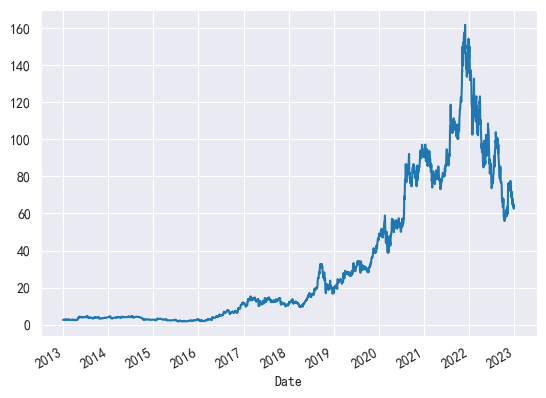

In [23]:
data["Close"].plot()
plt.show()

In [24]:
##获取标普500股票公司名字
import bs4 as bs
import requests

###爬取维基百科标普500公司名称
resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
soup = bs.BeautifulSoup(resp.text, 'lxml')
table = soup.find('table', {'class': 'wikitable sortable'})

###筛选元素
tickers = []
for row in table.findAll('tr')[1:]:
   ticker = row.findAll('td')[0].text
   ticker=ticker.replace("\n","")
   tickers.append(ticker)


tickers

['MMM',
 'AOS',
 'ABT',
 'ABBV',
 'ACN',
 'ATVI',
 'ADM',
 'ADBE',
 'ADP',
 'AAP',
 'AES',
 'AFL',
 'A',
 'APD',
 'AKAM',
 'ALK',
 'ALB',
 'ARE',
 'ALGN',
 'ALLE',
 'LNT',
 'ALL',
 'GOOGL',
 'GOOG',
 'MO',
 'AMZN',
 'AMCR',
 'AMD',
 'AEE',
 'AAL',
 'AEP',
 'AXP',
 'AIG',
 'AMT',
 'AWK',
 'AMP',
 'ABC',
 'AME',
 'AMGN',
 'APH',
 'ADI',
 'ANSS',
 'AON',
 'APA',
 'AAPL',
 'AMAT',
 'APTV',
 'ACGL',
 'ANET',
 'AJG',
 'AIZ',
 'T',
 'ATO',
 'ADSK',
 'AZO',
 'AVB',
 'AVY',
 'AXON',
 'BKR',
 'BALL',
 'BAC',
 'BBWI',
 'BAX',
 'BDX',
 'WRB',
 'BRK.B',
 'BBY',
 'BIO',
 'TECH',
 'BIIB',
 'BLK',
 'BK',
 'BA',
 'BKNG',
 'BWA',
 'BXP',
 'BSX',
 'BMY',
 'AVGO',
 'BR',
 'BRO',
 'BF.B',
 'BG',
 'CHRW',
 'CDNS',
 'CZR',
 'CPT',
 'CPB',
 'COF',
 'CAH',
 'KMX',
 'CCL',
 'CARR',
 'CTLT',
 'CAT',
 'CBOE',
 'CBRE',
 'CDW',
 'CE',
 'CNC',
 'CNP',
 'CDAY',
 'CF',
 'CRL',
 'SCHW',
 'CHTR',
 'CVX',
 'CMG',
 'CB',
 'CHD',
 'CI',
 'CINF',
 'CTAS',
 'CSCO',
 'C',
 'CFG',
 'CLX',
 'CME',
 'CMS',
 'KO',
 'CTSH',
 'CL',

In [25]:
def getStockDataInYFinance(name,start='2013-01-1',end='2023-01-01'):
    includedList=['country','zip','industry','sector']
    data = yf.download(tickers=name,start=start,end=end)
    data['trade_date'] = data.index
    company = yf.Ticker(name)
    try:
        companyInfo=pd.DataFrame.from_dict(company.info)
    except BaseException:
        print(company.info)
        return np.nan
    else:
        data['name']=[name]*data.shape[0]
        for column in companyInfo.columns:
            if column in includedList:
                data[column]=np.array([companyInfo[column].values[0]]).repeat(data.shape[0])

    return data


### get all stock data and store them
def storeAllStockDataForYFinance():
    now=datetime.now()
    allStockDataInYFinance=pd.DataFrame()
    for company in tickers:
        companyInfo=getStockDataInYFinance(company)
        if companyInfo is np.nan:
            print("break, company {} data is null")
            continue
        else:
            allStockDataInYFinance=allStockDataInYFinance.append(companyInfo)
    print("Cost time: {}".format(datetime.now()-now))
    return allStockDataInYFinance

In [26]:
getStockDataInYFinance(tickers[0]).dtypes

[*********************100%***********************]  1 of 1 completed


Open                 float64
High                 float64
Low                  float64
Close                float64
Adj Close            float64
Volume                 int64
trade_date    datetime64[ns]
name                  object
zip                   object
country               object
industry              object
sector                object
dtype: object

In [27]:
###仅用于下载yfinance 股票数据
# stockDataInYFinance=storeAllStockDataForYFinance()
# stockDataInYFinance.to_csv('stockData/YFinanceRawData.csv', header=stockDataInYFinance.columns,index=False)

In [28]:
###验证一下有多少个查漏了
stockDataInYFinance=pd.read_csv('stockData/YFinanceRawData.csv')
uniqueCompany=stockDataInYFinance['name'].unique()
missedList=[]
for ticker in tickers:
    if ticker not in uniqueCompany:
        missedList.append(ticker)

print("length of miss company: {}".format(len(missedList)))
###总共有3个公司遗漏

###手动查询
for company in missedList:
    print("------------------------------------------------------")
    print("This is the information for {}".format(company))
    print(getStockDataInYFinance(name=company))
    print("------------------------------------------------------")
###经过调查，属于信息不完善，有的连公司信息都不全

length of miss company: 4
------------------------------------------------------
This is the information for BRK.B
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- BRK.B: No timezone found, symbol may be delisted
{'maxAge': 86400, 'priceHint': 2, 'quoteType': 'EQUITY', 'symbol': 'BRK.B', 'underlyingSymbol': 'BRK.B', 'uuid': '5a2c1675-19de-345f-a8c3-a61c958d64f1', 'trailingPegRatio': None}
nan
------------------------------------------------------
------------------------------------------------------
This is the information for BF.B
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- BF.B: No data found for this date range, symbol may be delisted
{'exchange': 'YHD', 'quoteType': 'MUTUALFUND', 'symbol': 'BF.B', 'underlyingSymbol': 'BF.B', 'timeZoneFullName': 'America/New_York', 'timeZoneShortName': 'EDT', 'uuid': '69748612-d5d0-36f5-be88-ea00a370321d', 'gmtOffSetMilliseconds': -14400000, 'maxAge': 86400, 't

In [29]:
print("types in data: {}".format(stockDataInYFinance.dtypes))
stockDataInYFinance

types in data: Open          float64
High          float64
Low           float64
Close         float64
Adj Close     float64
Volume          int64
trade_date     object
name           object
zip            object
country        object
industry       object
sector         object
dtype: object


,Open,High,Low,Close,Adj Close,Volume,trade_date,name,zip,country,industry,sector
0,94.190002,94.790001,93.959999,94.779999,69.957985,3206700,2013-01-02,MMM,55144-1000,United States,Conglomerates,Industrials
1,94.339996,94.930000,94.129997,94.669998,69.876778,2704600,2013-01-03,MMM,55144-1000,United States,Conglomerates,Industrials
2,94.790001,95.480003,94.540001,95.370003,70.393486,2704900,2013-01-04,MMM,55144-1000,United States,Conglomerates,Industrials
3,95.019997,95.730003,94.760002,95.489998,70.482063,2745800,2013-01-07,MMM,55144-1000,United States,Conglomerates,Industrials
4,95.169998,95.750000,95.099998,95.500000,70.489418,2655500,2013-01-08,MMM,55144-1000,United States,Conglomerates,Industrials
...,...,...,...,...,...,...,...,...,...,...,...,...
1225184,144.509995,145.889999,143.539993,145.759995,145.106659,1017900,2022-12-23,ZTS,07054,United States,Drug Manufacturers—Specialty & Generic,Healthcare
1225185,145.910004,146.149994,143.570007,145.300003,144.648743,957900,2022-12-27,ZTS,07054,United States,Drug Manufacturers—Specialty & Generic,Healthcare
1225186,145.179993,146.639999,143.770004,143.830002,143.185333,1443900,2022-12-28,ZTS,07054,United States,Drug Manufacturers—Specialty & Generic,Healthcare
1225187,145.199997,148.509995,145.139999,148.149994,147.485947,1298900,2022-12-29,ZTS,07054,United States,Drug Manufacturers—Specialty & Generic,Healthcare


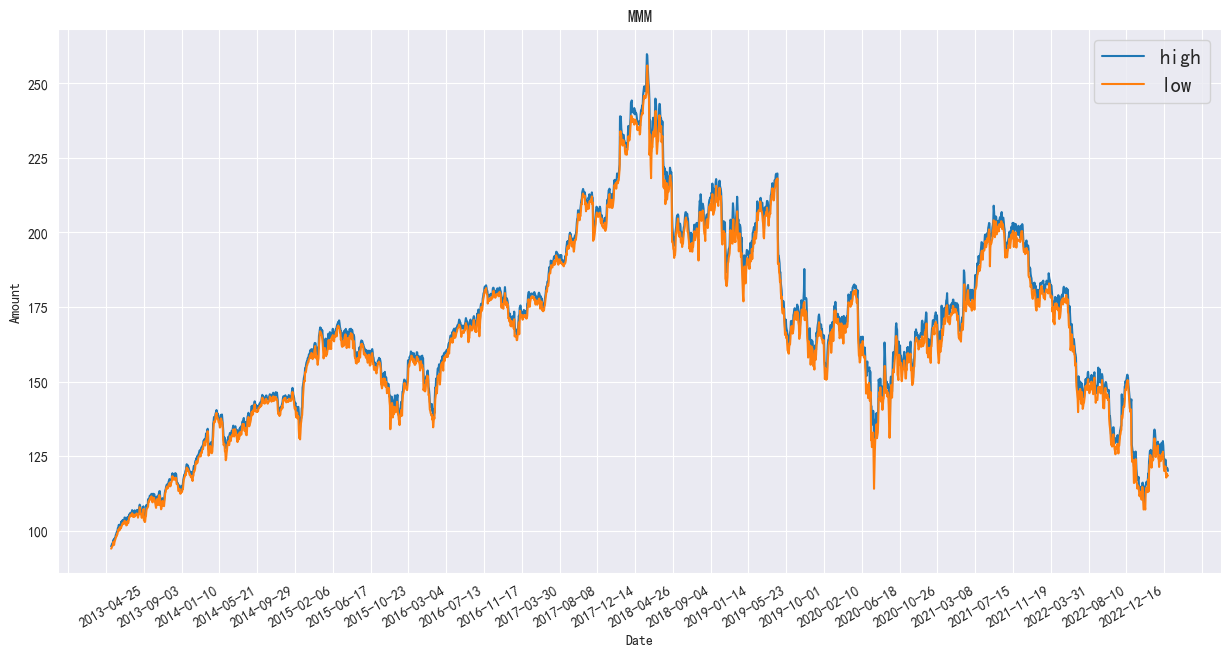

,Open,High,Low,Close,Adj Close,Volume,trade_date,name,zip,country,industry,sector
0,94.190002,94.790001,93.959999,94.779999,69.957985,3206700,2013-01-02,MMM,55144-1000,United States,Conglomerates,Industrials
1,94.339996,94.930000,94.129997,94.669998,69.876778,2704600,2013-01-03,MMM,55144-1000,United States,Conglomerates,Industrials
2,94.790001,95.480003,94.540001,95.370003,70.393486,2704900,2013-01-04,MMM,55144-1000,United States,Conglomerates,Industrials
3,95.019997,95.730003,94.760002,95.489998,70.482063,2745800,2013-01-07,MMM,55144-1000,United States,Conglomerates,Industrials
4,95.169998,95.750000,95.099998,95.500000,70.489418,2655500,2013-01-08,MMM,55144-1000,United States,Conglomerates,Industrials
...,...,...,...,...,...,...,...,...,...,...,...,...
2513,120.790001,121.000000,117.800003,120.139999,118.570084,2609300,2022-12-23,MMM,55144-1000,United States,Conglomerates,Industrials
2514,120.139999,120.830002,119.160004,120.220001,118.649040,1811200,2022-12-27,MMM,55144-1000,United States,Conglomerates,Industrials
2515,120.349998,121.000000,118.250000,118.290001,116.744263,1961000,2022-12-28,MMM,55144-1000,United States,Conglomerates,Industrials
2516,118.870003,120.860001,118.500000,120.570000,118.994469,2060800,2022-12-29,MMM,55144-1000,United States,Conglomerates,Industrials


In [30]:
MMMStock=stockDataInYFinance[stockDataInYFinance['name']=="MMM"]

plt.figure(figsize=(15,8))

ax = plt.gca()
locator = mdates.DayLocator(interval=30*3)
ax.xaxis.set_major_locator(locator)

x=MMMStock['trade_date']

plt.plot(x,MMMStock['High'],label="high")
plt.plot(x,MMMStock['Low'],label="low")
plt.gcf().autofmt_xdate()
plt.xlabel("Date")
plt.ylabel("Amount")
plt.title('MMM')
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rcParams.update({'font.size': 15})
plt.legend()   #打上标签
plt.show()
MMMStock

# 2.0 Analysis the raw data in AI
* data engineering
* data cleaning
* build model
* train

------------------------------------------
这里说一下训练集与验证集的分配:
* 训练集: 截取 2013-01-01 to 2018-01-01，5年数据，占总比50%。
* 验证集1: 截取 2018-01-01 to 2019-01-01 1年数据， 占总比10%，因为疫情就发生在2019年，该验证集用于检测模型准确度，确保该模型在疫情前时期可以正常使用
* 验证集2: 截取 2019-01-01 to 2023-01-01 4年数据，占比40%，该数据集并非用于验证，而是在确保验证集1能正常运行的情况下，用于观察疫情发生与正常预期是否有大偏差（验证是否疫情对股票市场有巨大影响）